# Explore Cell State with PCA

In [7]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

import sys
sys.path.append("/home/tommy/ml_drought")

In [2]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
%load_ext autoreload
%autoreload 2

# Load in all of the raw data (original)

In [5]:
# all_data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)

# Load in the Cell State Data

In [12]:
from scripts.drafts.cell_state_extract import (load_config_file, load_ealstm, load_lstm, load_normalised_cs_data, normalize_xr_by_basin)
from scripts.drafts.gb_sm_data import (read_gb_sm_data)

In [13]:
run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"
config = load_config_file(run_dir)
model = load_ealstm(config)


lstm_run_dir = data_dir / "runs/ensemble/lstm_ensemble6_nse_1998_2008_2710_171032"
lstm_config = load_config_file(lstm_run_dir)
lstm_model = load_lstm(lstm_config)

In [15]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
TEST_BASINS = [str(id_) for id_ in catchment_ids]
FINAL_VALUE = True
TEST_TIMES = pd.date_range(config.test_start_date, config.test_end_date, freq="D")

norm_cs_data = load_normalised_cs_data(
    config=config,
    model=model,
    test_basins=TEST_BASINS,
    test_times=TEST_TIMES,
    final_value=FINAL_VALUE,
)

Normalize: 100%|██████████| 64/64 [00:00<00:00, 1181.47it/s]


# Load in SM data

In [16]:
sm = read_gb_sm_data(data_dir)
norm_sm = normalize_xr_by_basin(sm)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# Reduce dimensions (PCA)

In [33]:
norm_cs_data = norm_cs_data

In [42]:
from sklearn.decomposition import PCA
from typing import Tuple, Dict, DefaultDict, Union, Optional, Any


def calculate_pca_on_cell_state(c_state: np.ndarray, n_pcs: int) -> Tuple[PCA, np.ndarray]:
    pca = PCA(n_components = n_pcs)
    first_pcs = []
    # LONG FORMAT
    if (len(c_state.shape) == 2):
        first_pcs = pca.fit_transform(c_state)
        
    # WIDE FORMAT
    else:
        for ts in range(c_state.shape[0]):
            new = pca.fit_transform(c_state[ts])
            first_pcs.append(new)
        first_pcs = np.array(first_pcs)
    return pca, first_pcs


def get_time_time_deltas(config) -> Tuple[np.ndarray, np.ndarray,]:
    s = config.test_start_date
    e = config.test_end_date
    times = pd.date_range(s, e, freq="1D")
    time_deltas = sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True)
    return times, time_deltas


def pca_to_xarray(pca_out: np.ndarray, cs_data: xr.Dataset) -> xr.Dataset:
    n_pcs = pca_out.shape[-1]
    # convert to an xarray dataset to keep an eye on time
    wide = True if len(pca_out.shape) == 3 else False
    # WIDE format (target_time, time_delta, PCs)
    if wide:
        times, time_deltas = get_time_time_deltas(config)
        all_pcs = []
        for ix in range(pca_out.shape[-1]): 
            pc = xr.Dataset(
                {f"pc{ix+1}": (["target_time", "time_delta"], np.squeeze(pca_out[:, :, ix]))},
                coords={"target_time": times.values, "time_delta": time_deltas}
            )
            all_pcs.append(pc)

        pcs = xr.merge(all_pcs)

    # LONG format (actual_time, PCs)
    else:
        # create one station PC Xarray data
        pcs = xr.ones_like(
            cs_data["cell_state"]
            .rename({"dimension": "PC"})
            .isel(PC=slice(0, n_pcs))
            .sel(station_id=station)
        )
        assert pcs.shape == pca_out.shape
        pcs = pcs * pca_out
        if "target_time" in [d for d in cs_data.dims]:
            pcs["target_time"] = cs_data["target_time"]
        else:
            pcs["target_time"] = cs_data["time"]
        pcs = pcs.expand_dims("station_id")
        try:
            pcs = pcs.rename({"cell_state": "values"})
        except ValueError:
            pcs = pcs.rename("value")
    return pcs



N_PCS = 10
mean = False

# if not (data_dir / "13_all_pca.nc").exists() or not (data_dir / "pca_items.pkl").exists():
mean_xarrays = []
pca_items = {}
for ix, station in enumerate(tqdm(norm_cs_data.station_id.values)):
    c_state = norm_cs_data.sel(station_id=station).values
    pca, pca_out = calculate_pca_on_cell_state(c_state, N_PCS)

    # print("-- Converting PCs to Xarray --")
    pcs = pca_to_xarray(pca_out, norm_cs_data.to_dataset())
    # NOTE: multiple values for each timestep
    # collapse by mean ?
    if mean:
        pcs_mean = pcs.drop("target_time").groupby("time").mean()
        try:
            pcs_mean = pcs_mean.rename({"cell_state": "values"})
        except ValueError:
            pcs_mean = pcs_mean.rename("value")
    else:
        pcs_mean = pcs
    mean_xarrays.append(pcs_mean)
    pca_items[station] = pca

    del pcs

print("-- Combining into one xarray --")
all_pca = xr.concat(mean_xarrays, dim="station_id")
    
#     # save outputs
#     all_pca.to_netcdf(data_dir / "13_all_pca.nc")
#     pickle.dump(pca_items, (data_dir / "pca_items.pkl").open("wb"))

# else:
#     all_pca = xr.open_dataset(data_dir / "13_all_pca.nc")["value"]
#     pca_items = pickle.load((data_dir / "pca_items.pkl").open("rb"))

100%|██████████| 13/13 [00:00<00:00, 88.58it/s]

-- Combining into one xarray --


In [43]:
# Check the data is not matching
id0 = all_pca.isel(station_id=0).isel(time=slice(0, 10))
id1 = all_pca.isel(station_id=1).isel(time=slice(0, 10))

print(f"{np.isclose(id0.values, id1.values).mean() * 100}% Data is Matching")
assert np.isclose(id0.values, id1.values).mean() < 1, "-- all_pca object is fucked -- "
print("-- all_pca object is great! --")

0.0% Data is Matching
-- all_pca object is great! --


In [44]:
all_pca

<xarray.DataArray 'value' (station_id: 13, time: 4018, PC: 10)>
array([[[ 6.54862165e+00, -1.22682726e+00,  2.25995684e+00, ...,
          1.06260935e-02,  1.46760559e+00, -7.02439070e-01],
        [ 1.02992811e+01,  4.49461877e-01,  1.42395973e+00, ...,
         -7.97570825e-01,  6.97635487e-02,  1.24011433e+00],
        [ 1.07870121e+01, -7.25213706e-01, -7.21350968e-01, ...,
          2.19016615e-02,  1.04277003e+00, -1.45570710e-01],
        ...,
        [-1.41620016e+00, -3.29894996e+00,  2.48317409e+00, ...,
          4.23482746e-01, -4.17712778e-01, -2.68456936e-01],
        [-1.85256052e+00, -3.66117811e+00,  2.70231462e+00, ...,
          9.53533053e-01, -2.23732784e-01, -2.59148210e-01],
        [-2.29064250e+00, -3.71970439e+00,  2.95477605e+00, ...,
          1.10031450e+00, -3.47542375e-01, -5.01141965e-01]],

       [[ 7.60495377e+00, -3.99193257e-01, -3.14615679e+00, ...,
         -9.03173685e-01, -8.02905738e-01,  9.05791402e-01],
        [ 1.07903585e+01,  1.43537664e+00, -3.00964284e+00, ...,
         -1.06524241e+00, -1.61582100e+00,  5.33840656e-01],
        [ 1.49764442e+01,  5.50742245e+00, -2.98441935e+00, ...,
         -9.76127326e-01, -4.50250864e+00, -5.29835075e-02],
        ...,
        [-6.57907724e-01, -2.45438600e+00,  1.93333220e+00, ...,
         -4.33595419e-01, -4.43322301e-01,  9.39503536e-02],
        [-1.27319348e+00, -2.37882495e+00,  2.40843654e+00, ...,
          2.15936804e+00, -6.42498910e-01,  4.83067811e-01],
        [-2.49130034e+00, -1.92804003e+00,  2.43567014e+00, ...,
          2.15944409e+00, -6.31225824e-01,  1.73193872e-01]],

       [[ 8.75240326e+00, -2.61624366e-01,  3.54260468e+00, ...,
          3.32992733e-01,  5.59321456e-02,  7.50108421e-01],
        [ 1.61866283e+01,  4.30854130e+00,  2.86337256e+00, ...,
          3.84932309e-01, -9.15446877e-01,  2.74190950e+00],
        [ 1.76029377e+01,  9.51099157e-01, -2.42446423e+00, ...,
          1.03966840e-01,  3.97951841e-01,  1.96683097e+00],
        ...,
        [-1.61665058e+00, -2.22252321e+00,  1.15053439e+00, ...,
         -4.64372545e-01, -2.33316585e-01,  3.00223887e-01],
        [-1.93258750e+00, -2.52421951e+00,  1.26730227e+00, ...,
         -1.99951041e+00,  8.81093919e-01,  6.87264979e-01],
        [-2.21460390e+00, -3.05129313e+00,  1.72571242e+00, ...,
         -4.68254948e+00,  2.97136998e+00,  1.07534540e+00]],

       ...,

       [[ 7.68993092e+00,  2.88150024e+00, -1.59168732e+00, ...,
          6.81774437e-01,  1.12732494e+00, -9.47414339e-01],
        [ 1.53343210e+01,  8.19477463e+00,  2.52177149e-01, ...,
          5.49763262e-01,  4.08627659e-01, -7.77048692e-02],
        [ 1.94792480e+01,  3.34332752e+00,  3.51826262e+00, ...,
         -1.20712698e+00, -2.43154183e-01, -1.13334799e+00],
        ...,
        [-1.62920213e+00, -9.49458480e-01, -3.10074663e+00, ...,
          6.82470739e-01, -4.82362717e-01,  1.14520538e+00],
        [-1.96953404e+00, -1.10132384e+00, -3.73830652e+00, ...,
          1.74204719e+00, -7.18709946e-01,  2.91840386e+00],
        [-2.27886915e+00, -1.23455203e+00, -4.37810612e+00, ...,
          2.84590483e+00, -9.31175232e-01,  4.82422543e+00]],

       [[ 5.69045162e+00, -1.90846479e+00, -1.82451200e+00, ...,
         -6.62375629e-01, -1.26694739e-01,  4.03014004e-01],
        [ 1.06327515e+01,  1.44207752e+00, -2.36866927e+00, ...,
         -1.16375053e+00, -8.70850384e-01, -4.48022872e-01],
        [ 1.06376476e+01, -1.54558241e+00,  1.87387180e+00, ...,
         -1.31976295e+00, -1.97812051e-01,  5.56123912e-01],
        ...,
        [-3.38106751e+00, -1.55194604e+00, -6.65558815e-01, ...,
          7.09722191e-02, -9.97059345e-02, -4.31861132e-02],
        [-3.82188725e+00, -1.63819575e+00, -7.97381580e-01, ...,
          1.97981358e+00, -2.50446111e-01, -1.55376285e-01],
        [-4.19255972e+00, -1.89294684e+00, -1.10792840e+00, ...,
          4.84979248e+00, -4.09730315e-01, -2.64755338e-01]],

       [[ 6.98322058e+00, -9.49427903e-01, -2.19260001e+00, ...,
   

In [45]:
print(pca_items["12002"].explained_variance_ratio_)
print(pca_items["15006"].explained_variance_ratio_)

[0.5330217  0.11826739 0.07967525 0.04761452 0.03520817 0.02390032
 0.0235377  0.01853288 0.01320617 0.01303013]
[0.5586969  0.1503324  0.05743945 0.04570312 0.031703   0.02568686
 0.01710118 0.01508668 0.0127972  0.00913367]


In [46]:
def plot_explained_variance(pca: PCA, ax = None):
    sns.barplot(x=np.arange(pca.n_components) + 1, y=pca.explained_variance_ratio_, color=sns.color_palette()[0], ax=ax)
    ax = plt.gca()
    ax.set_ylabel("Explained Variance (%)")
    ax.set_xlabel("Principal Component")
    sns.despine()

    print("%Explained:", [f"{pc:.2f}%" for pc in pca.explained_variance_ratio_])
    print("Cum%Explained:", [f"{pc:.2f}%" for pc in np.cumsum(pca.explained_variance_ratio_)])
    return ax

sids = [k for k in pca_items.keys()]

if False:
    fig, axs = plt.subplots(5, 3, figsize=(6*3, 4*5))

    for ix, station in enumerate(sids):
        pca = pca_items[station]
        ax = axs[np.unravel_index(ix, (5, 3))]
        ax.set_ylim(0, 0.5)
        ax.set_title(station)
        ax = plot_explained_variance(pca, ax=ax)

### Compare the Seasonality of normalised PC of C_n vs Seasonality of Q

In [47]:
from sklearn.preprocessing import StandardScaler


def get_normalised_df_from_dynamic(feature: str, station: int, config=config, ) -> pd.DataFrame:
    test_times, _ = get_time_time_deltas(config)
    scaler = StandardScaler()
    obs_data = scaler.fit_transform(
        dynamic.
        sel(station_id=int(station), time=test_times)[feature]
        .values
        .reshape(-1, 1)
    )
    
    norm_df = pd.DataFrame({"time": test_times, "norm_discharge": obs_data.flatten()})
    return norm_df



def plot_seasonality_of_pcs_vs_variable(
    pcs_data: xr.Dataset, 
    obs_var: pd.DataFrame, 
    pca: PCA, 
    visualise_n_pcs: int = 3,
    bground_obs_var: bool = False,
):
    assert all(np.isin(["PC", "station_id"], pcs_data.dims))
    assert all(np.isin(["time"], obs_var.columns))
    n_subplots = visualise_n_pcs + 1

    fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))
    station = pcs_data.station_id.values[0]
    station_name = static_df.loc[int(station), "gauge_name"]
    ax = axs[0]
    ax.set_title(f"Seasonality of PCAs for station: {station_name} - {station}")
    
    # Plot the observed data climatology
    obs_var["doy"] = obs_var["time"].dt.dayofyear
    obs_clim = obs_var.groupby("doy").mean()
    obs_clim.plot(ax=ax, color=sns.color_palette()[0])

    # Plot the n PCs
    for pc_ix in range(visualise_n_pcs):
        ax = axs[pc_ix + 1]
        data = pcs_data.sel(PC=pc_ix, station_id=station).to_dataframe()
        data = data.groupby(data.index.dayofyear).mean()
        data["value"].plot(ax=axs[pc_ix + 1], color=sns.color_palette(None, 11)[pc_ix + 1])
        ratio = pca.explained_variance_ratio_[pc_ix]
        ax.set_ylabel(f"Mean PC{pc_ix + 1}: {ratio*100:.0f}%")

        if pc_ix != visualise_n_pcs -1:
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_xlabel("")
        if bground_obs_var:
            ax2 = ax.twinx()
            obs_clim.plot(ax=ax2, alpha=0.5, color='grey')
            ax2.get_legend().remove()
            ax2.set_yticklabels([])
            ax2.set_yticks([])
    
    if bground_obs_var:
        # ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    else:
        sns.despine()
    
    return fig, axs



static_df = static.to_dataframe()

In [48]:
station = all_pca.station_id.values[0]
obs_q = get_normalised_df_from_dynamic("discharge_spec", station=station)
obs_q.head()

time  norm_discharge
0 1998-01-01        1.156072
1 1998-01-02        1.015286
2 1998-01-03        1.934795
3 1998-01-04        1.002087
4 1998-01-05        0.456541

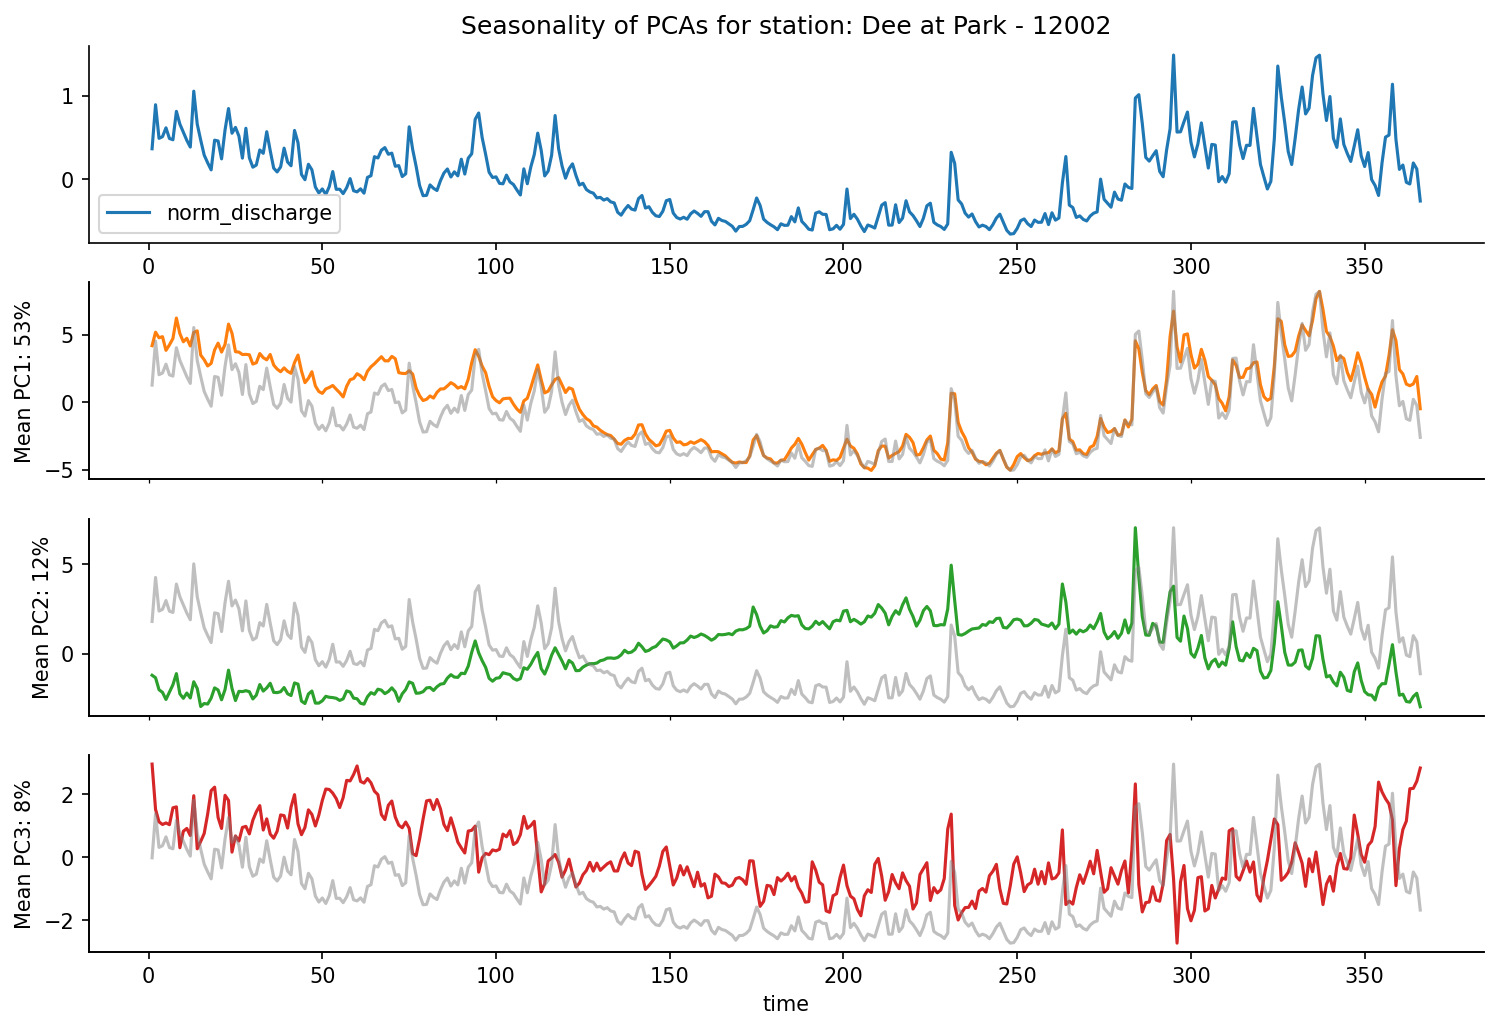

In [49]:
for station in all_pca.station_id.values:
    obs_q = get_normalised_df_from_dynamic("discharge_spec", station=station)
    fig, ax = plot_seasonality_of_pcs_vs_variable(
        all_pca.sel(station_id=[station]),
        obs_q,
        pca=pca_items[station],
        visualise_n_pcs=3,
        bground_obs_var=True,
    )
    sns.despine()
    break
    
    # fig.savefig(data_dir/f"RUNOFF/pca3_plots/{str(station)}.png")

# Compare to observed SM

In [50]:
def read_gb_sm_data() -> xr.Dataset:
    if not (data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc").exists():
        all_sm_ds = []
        for ix, path in enumerate(tqdm(list((data_dir / "RUNOFF/sm_data").glob("*Level*.csv")), desc="Reading SM Level")):
            # read in data
            df = (
                pd.read_table(d, sep=";", decimal=",")
                .drop("Unnamed: 0", axis=1)
                .rename({"Date": "time"}, axis=1)
                .astype({"time": "datetime64[ns]"})
            )
            # create index from station, time, rename column to soil level volume
            df = (
                df.melt(id_vars='time')
                .astype({"value": "float64", "variable": "int64"})
                .rename(
                    {
                        "value": f'swvl{path.name.split("Level_")[-1].replace(".csv", "")}',
                        "variable": "station_id"
                    }
                , axis=1)
                .set_index(["time", "station_id"])
            )    

            # convert to xarray
            ds = df.to_xarray()
            all_sm_ds.append(ds)

        ds = xr.combine_by_coords(all_sm_ds)
        ds.to_netcdf(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")


    else: 
        ds = xr.open_dataset(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")
    
    return ds

        
def old_read_obs_sm() -> xr.Dataset:
    # read in data
    obs_sm = pd.read_table(data_dir / "RUNOFF/Soil_Moisture_Catchments.csv", sep=";", decimal=",").drop("Unnamed: 0", axis=1)
    
    # convert to xarray
    sm_df = obs_sm.set_index("Date").stack().reset_index().rename({0: "soil_moisture", "level_1": "station_id", "Date": "time"}, axis=1)
    sm_df["time"] = pd.to_datetime(sm_df["time"])
    sm_df = sm_df.sort_values(["station_id", "time"]).set_index(["time", "station_id"])
    sm = sm_df.to_xarray()
    
    return sm

In [51]:
sm = read_gb_sm_data()
sm_df = sm.to_dataframe()

In [52]:
df = sm.groupby("time.dayofyear").std().mean(dim="station_id").to_dataframe()
df.head()

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


swvl1     swvl2     swvl3     swvl4
dayofyear                                        
1          0.019311  0.018356  0.022050  0.018227
2          0.019916  0.019342  0.022032  0.018258
3          0.020665  0.019695  0.022042  0.018294
4          0.019884  0.019624  0.022015  0.018327
5          0.019856  0.019204  0.021869  0.018367

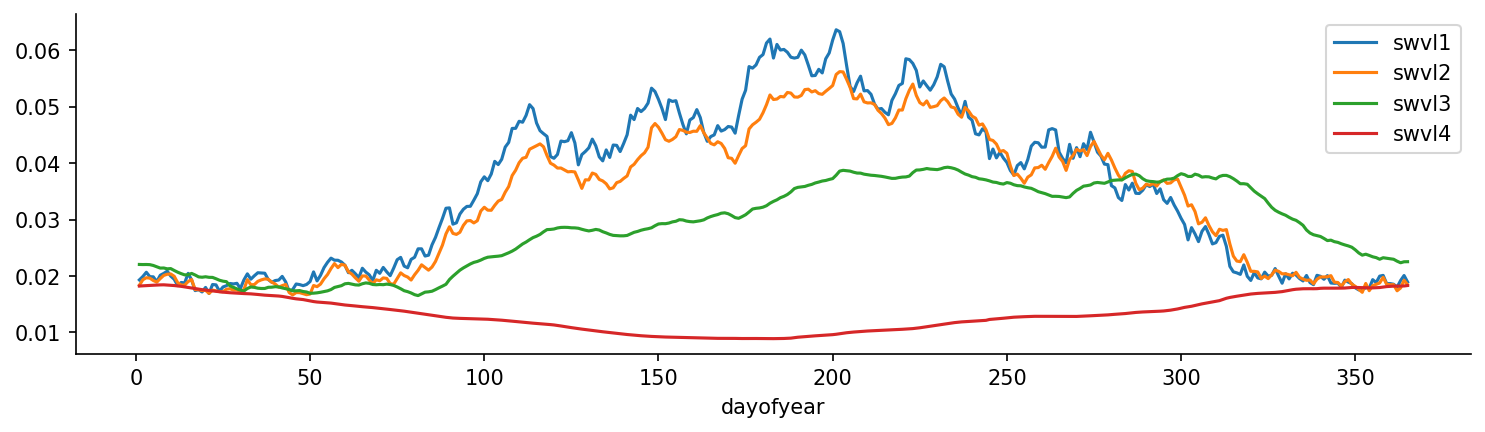

In [53]:
f, ax = plt.subplots(figsize=(12, 3))
df.iloc[:-1].plot(ax=ax)
sns.despine()

In [54]:
# NORMALIZE SM
def normalize_dataframe_by_basin(df: pd.DataFrame):
    assert all(np.isin(["time", "station_id"], df.reset_index().columns))
    scaler = StandardScaler()
    norm_ = df.groupby("station_id").apply(lambda x: scaler.fit_transform(x).flatten())

    norm_df = norm_.explode().reset_index().rename({0: "norm"}, axis=1).astype({"norm": "float64"})
    norm_df["time"] = df.reset_index().sort_values(["station_id", "time"])["time"]
    norm_df = norm_df.set_index(["station_id", "time"])
    
    return  norm_df


def normalize_xr_by_basin(ds):
    return (ds - ds.mean(dim="time")) / ds.std(dim="time")

In [55]:
norm_sm = normalize_xr_by_basin(sm)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [56]:
norm_sm = normalize_xr_by_basin(sm)
norm_climatology = norm_sm.groupby("time.dayofyear").mean(dim="time")
norm_pca = all_pca.groupby("time.dayofyear").mean(dim="time")

### Plot multiple SWLs

In [57]:
def plot_obs_pca_clim(
    norm_climatology: xr.Dataset,
    norm_pca: xr.Dataset,
    station: str,
    pca: PCA,
    visualise_n_pcs: int = 3,
):
    # 1. calculate the climatology
    obs_clim = norm_climatology.sel(station_id=station).drop("station_id").to_dataframe()
    pca_clim = norm_pca.sel(station_id=station).drop("station_id").to_dataframe().reset_index("PC").pivot(columns="PC", values="value")
    pca_clim.columns = [f"PC_{c + 1}" for c in pca_clim.columns]

    # 2. create plot figure
    n_subplots = visualise_n_pcs + 1
    fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))

    # 3. plot the observations (soil moisture)
    ax = axs[0]
    station_name = str(static["gauge_name"].to_dataframe().loc[int(station)].values)
    ax.set_title(f"Seasonality of PCAs for station: {station_name} - {station}")
    obs_clim.plot(ax=ax)

    # 4. plot each PC
    for ix in range(visualise_n_pcs):
        ax = axs[ix + 1]
        # plot the pca daat
        pc_data = pca_clim.loc[:, f"PC_{ix + 1}"]
        ax.plot(pc_data.index, pc_data.values)

        ratio = pca.explained_variance_ratio_[ix]
        ax.set_ylabel(f"Mean PC{ix + 1}: {ratio*100:.0f}%")
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")

        # plot bground observation data
        ax2 = ax.twinx()
        obs_clim.plot(ax=ax2, alpha=0.5, color='grey')
        ax2.get_legend().remove()
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        None if ax2.get_legend() is None else ax2.get_legend().remove()

    return fig, ax

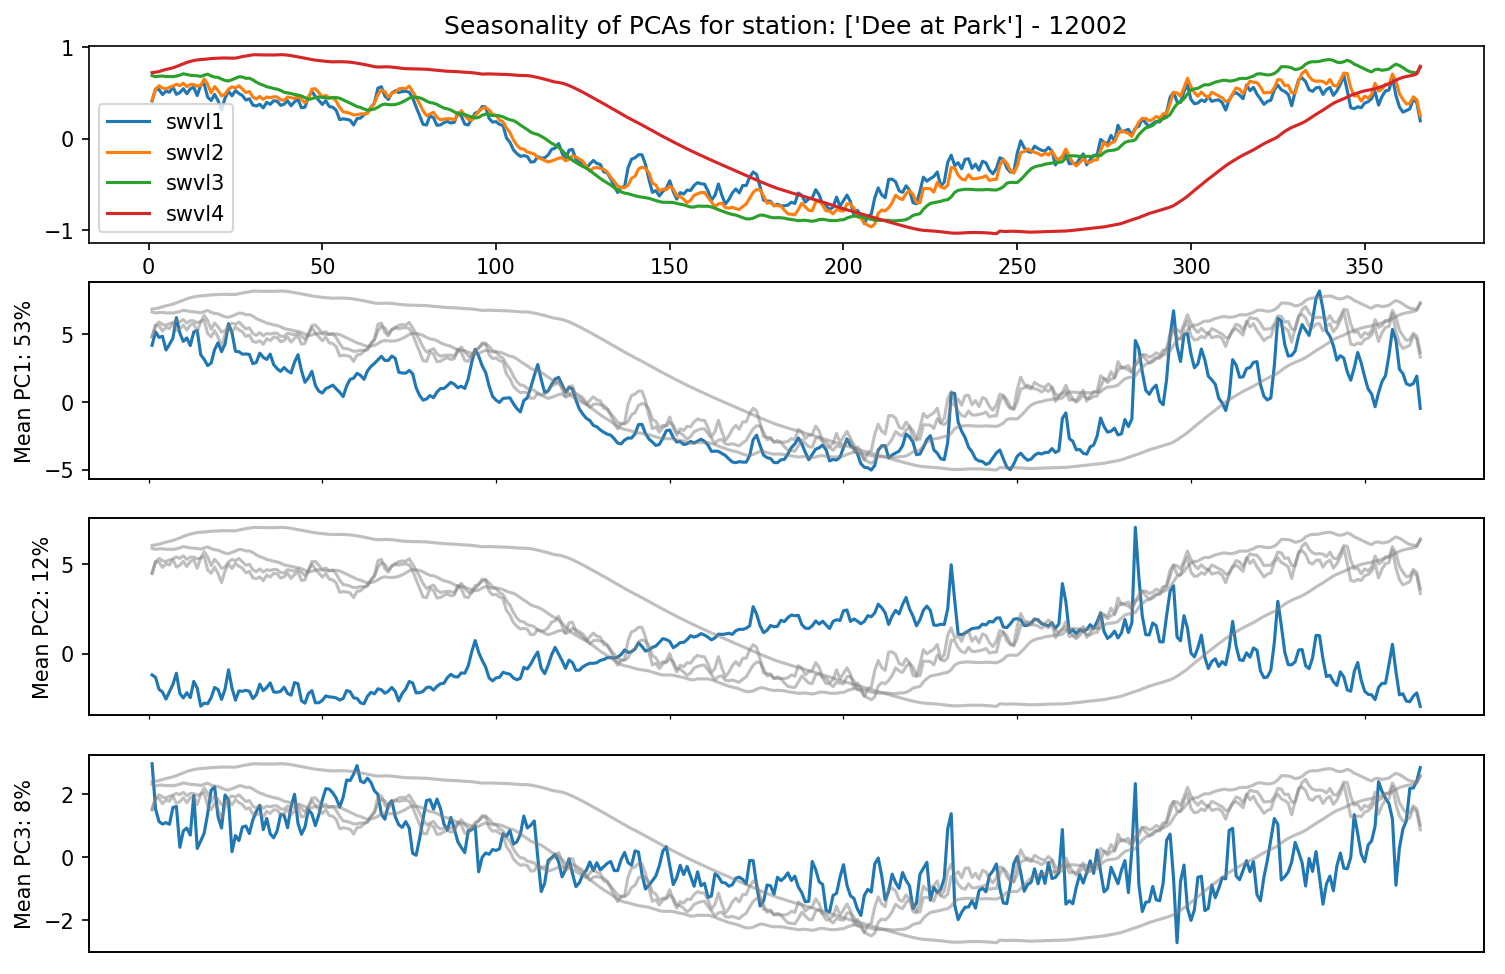

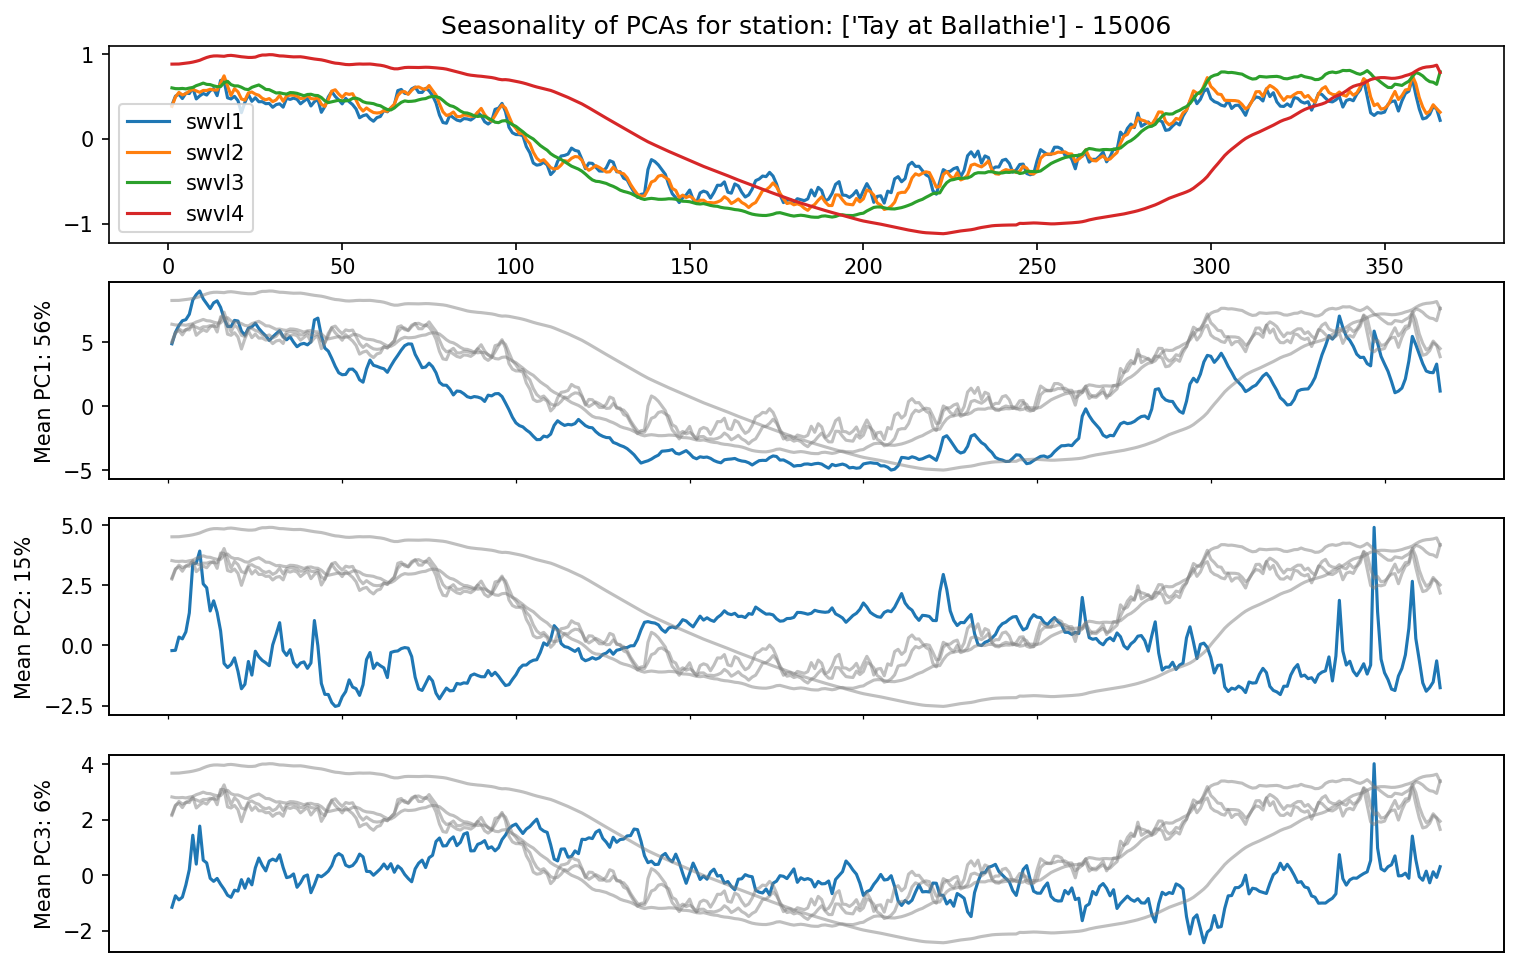

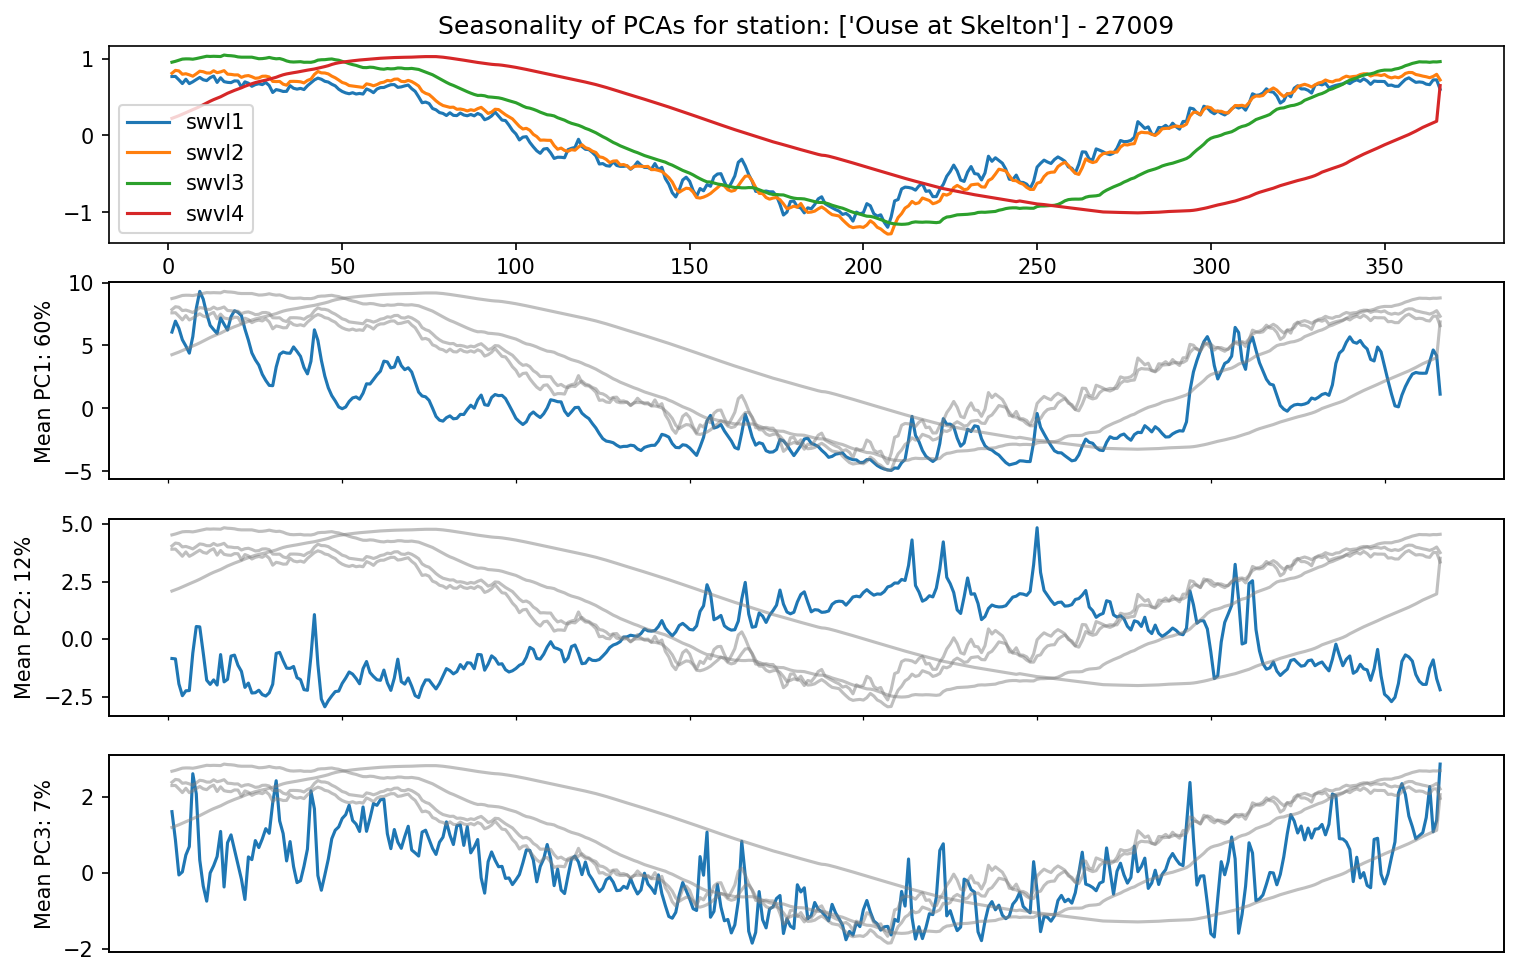

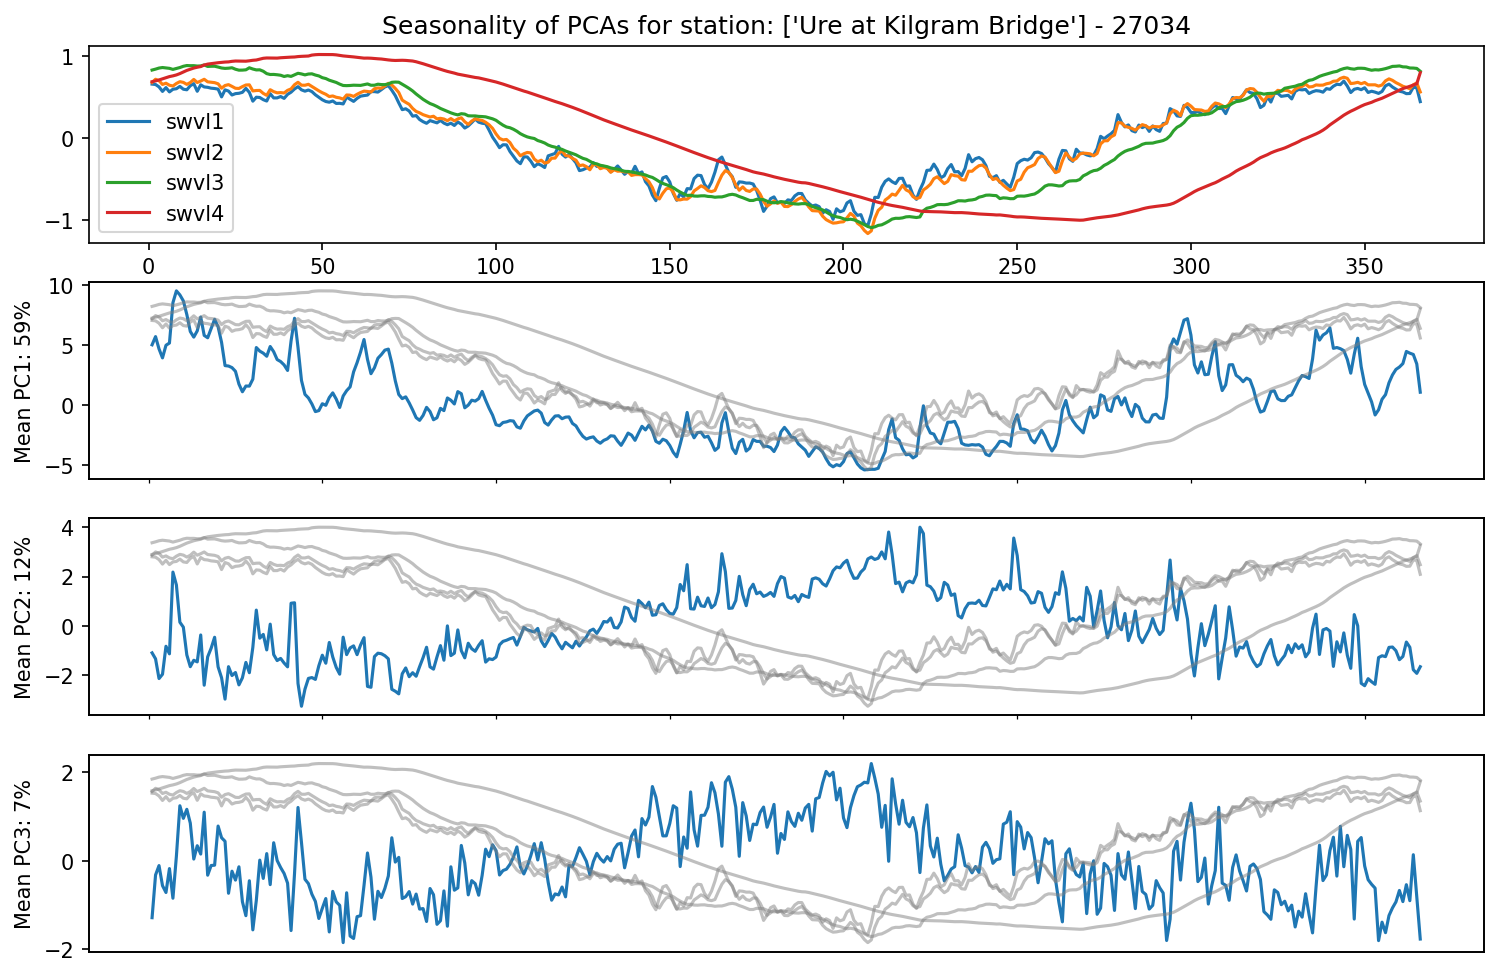

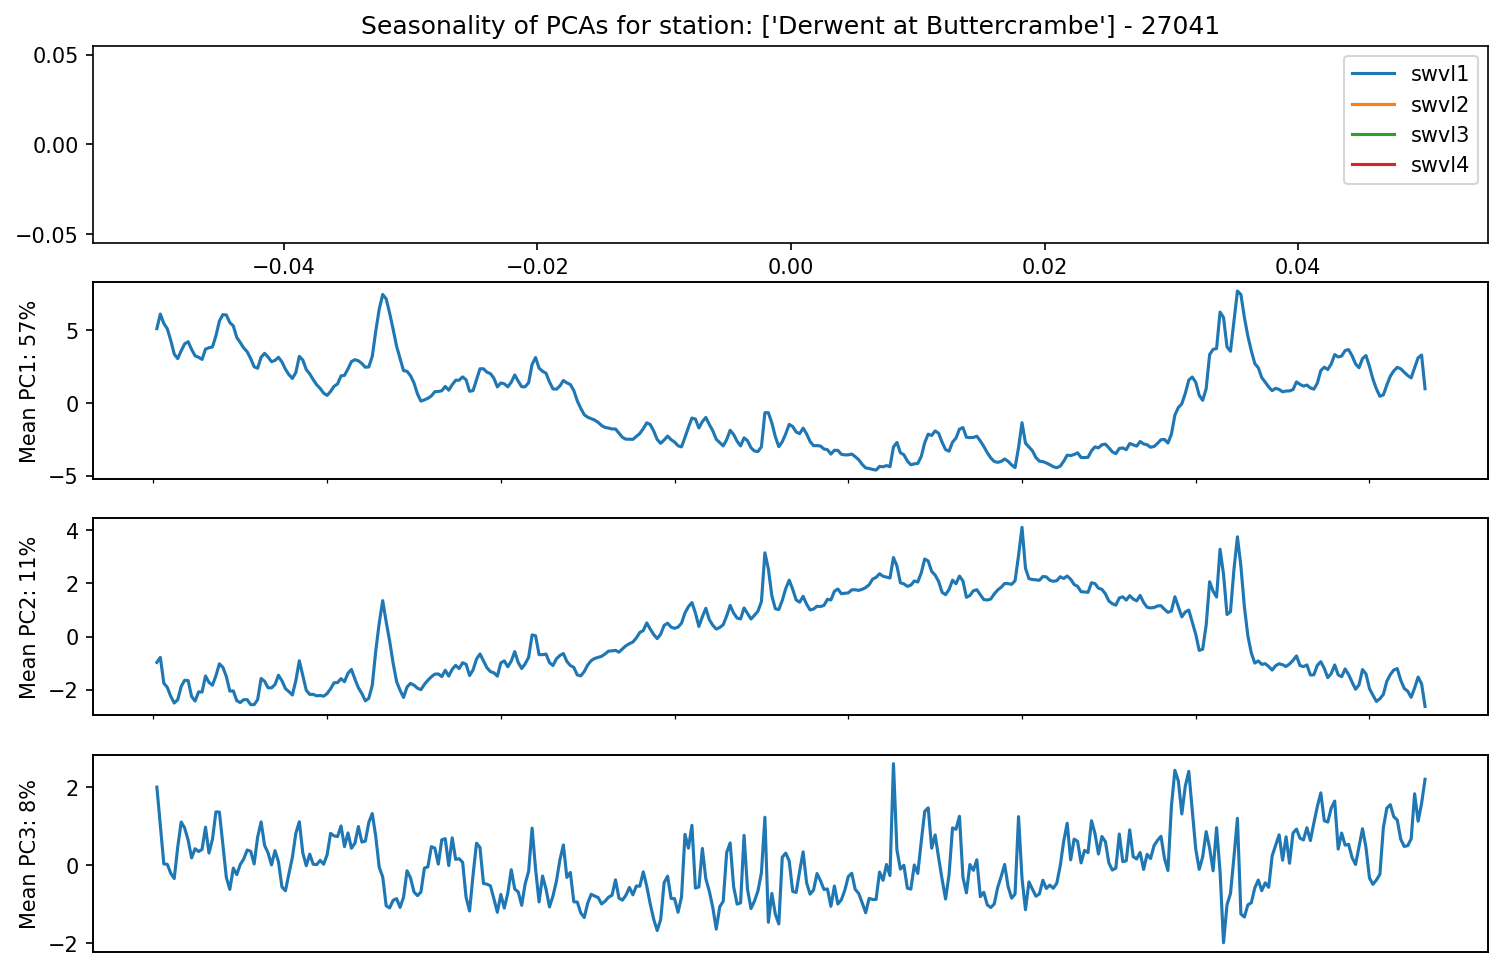

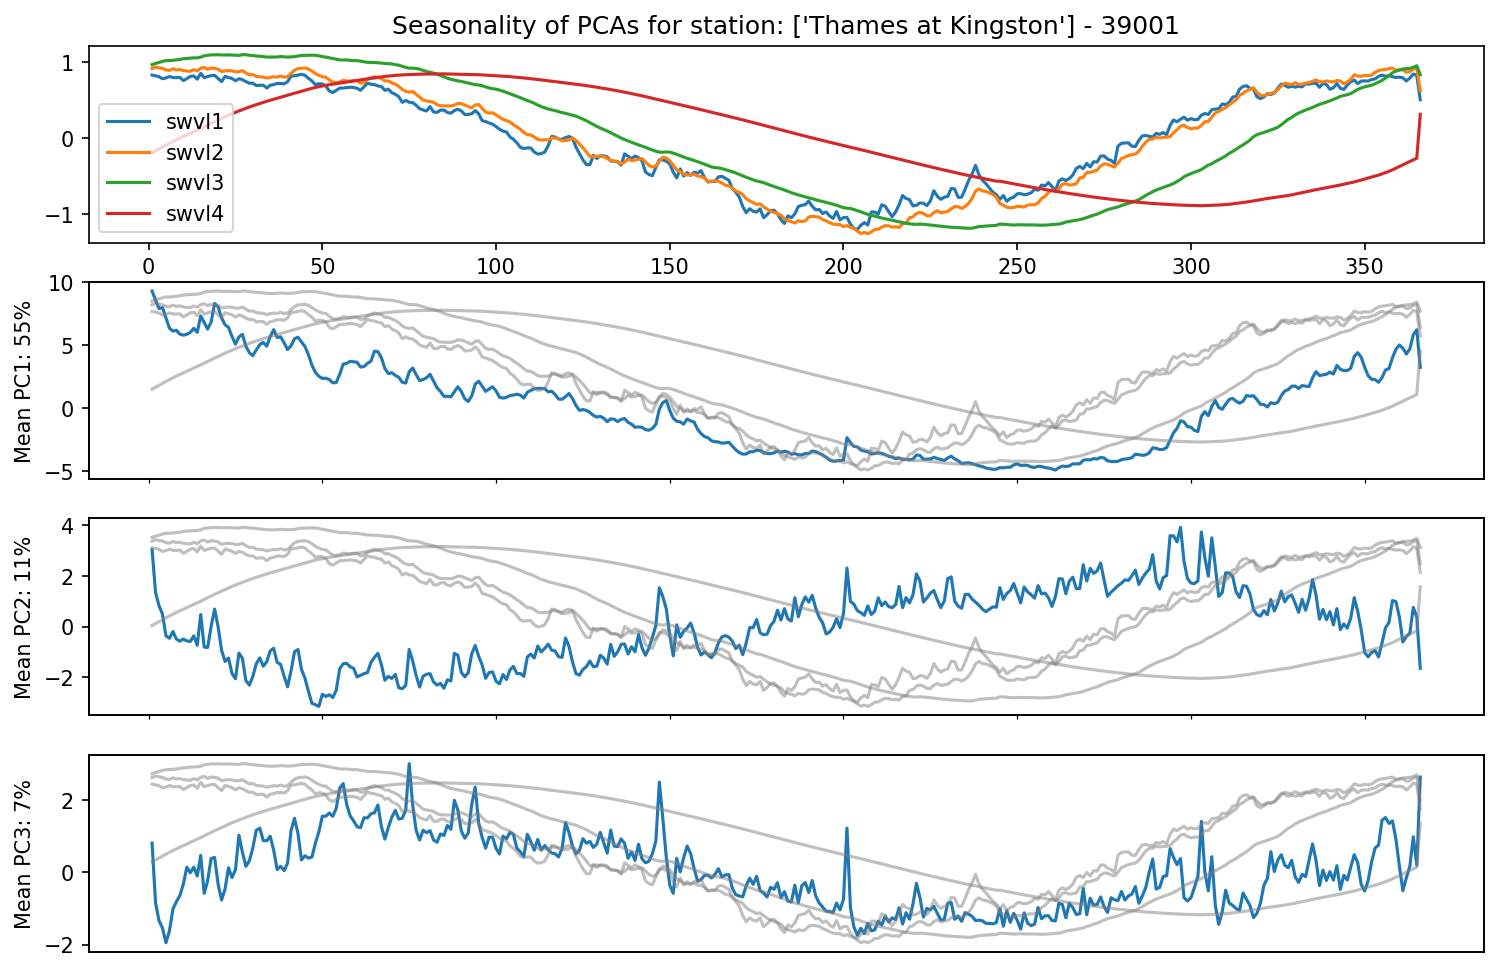

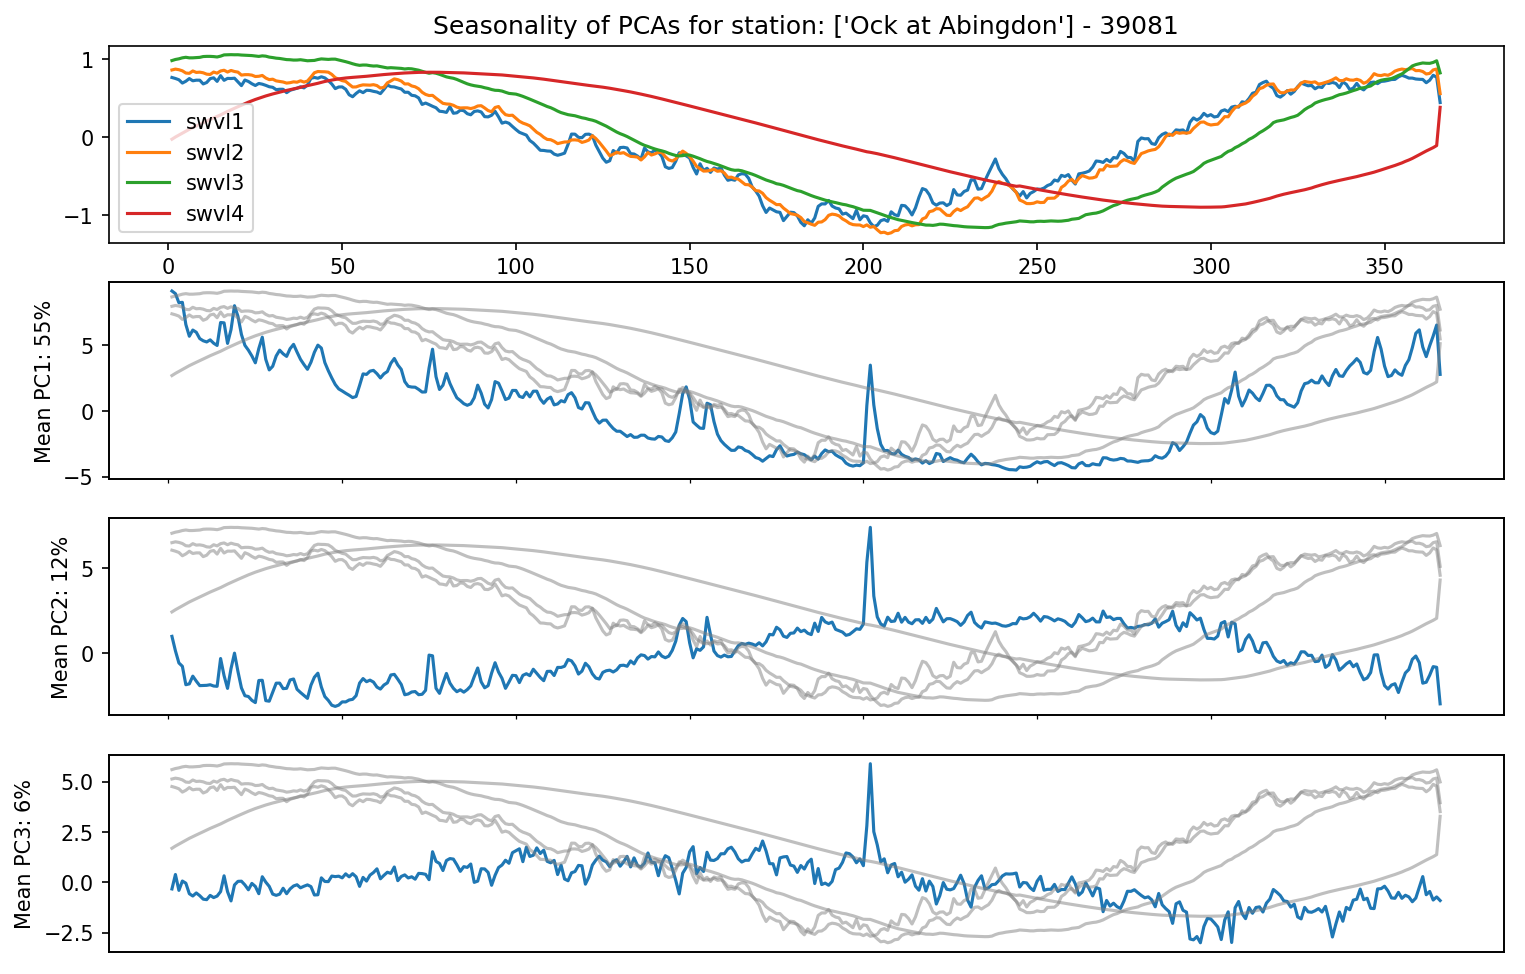

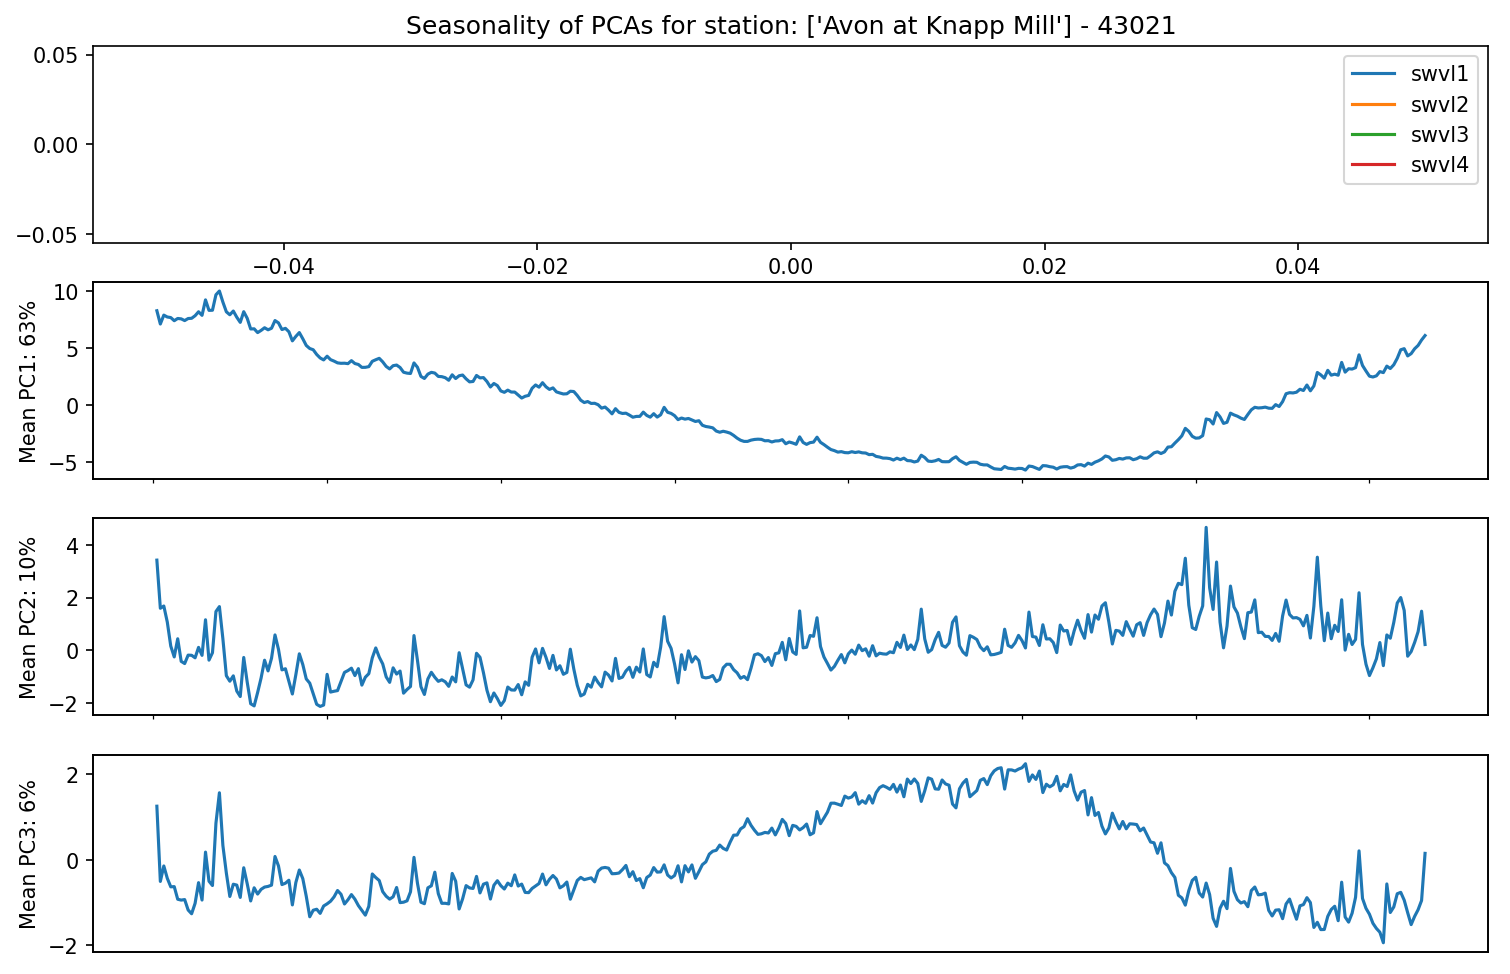

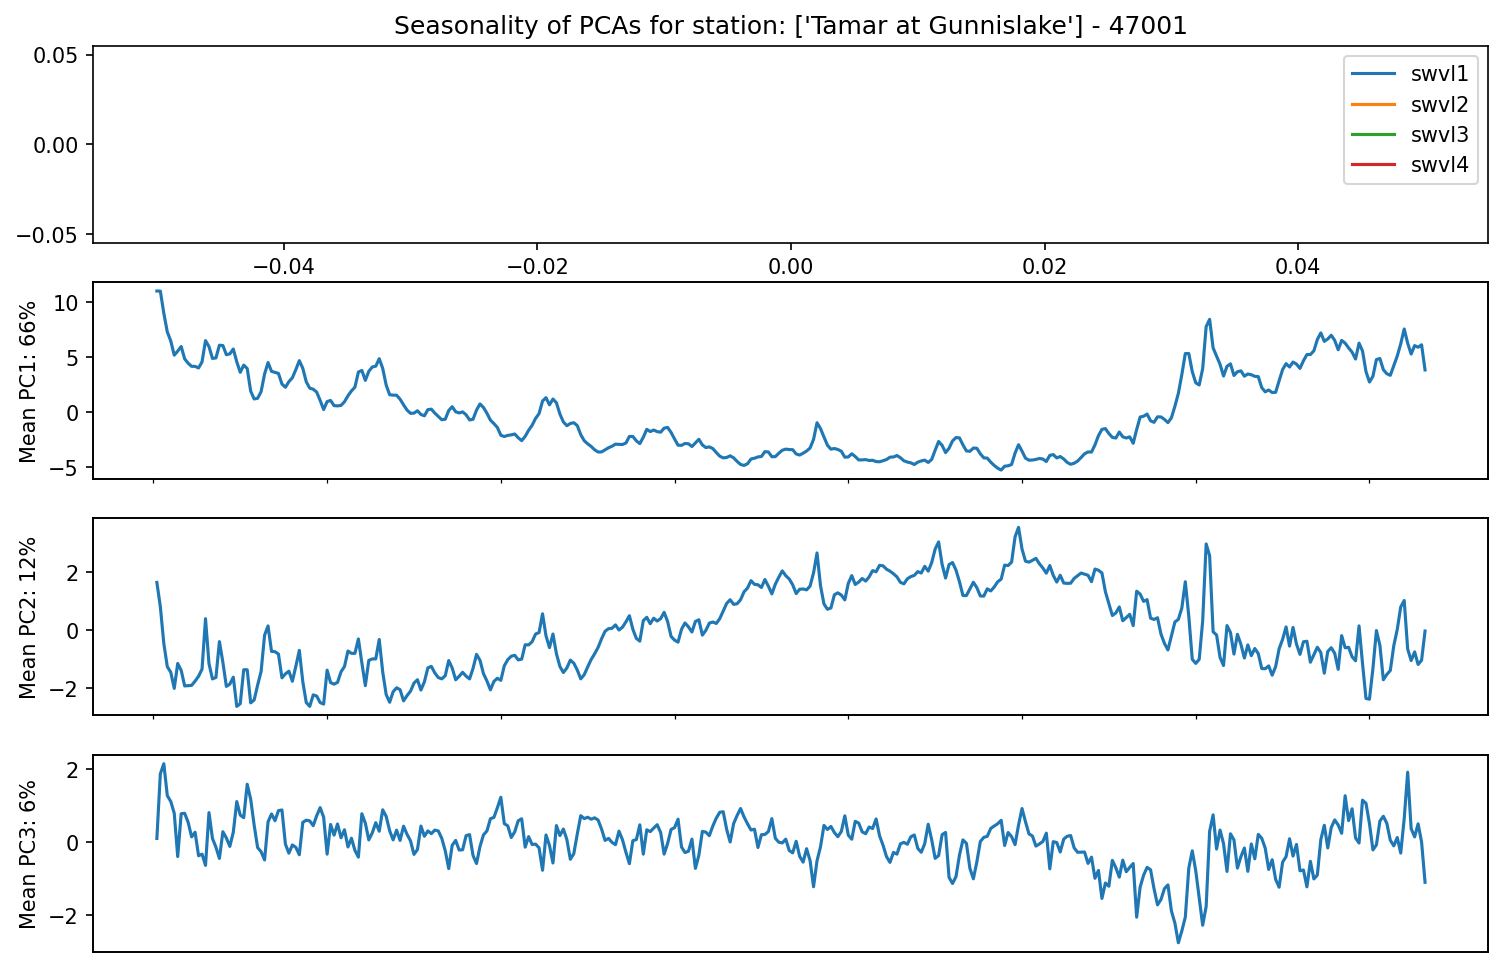

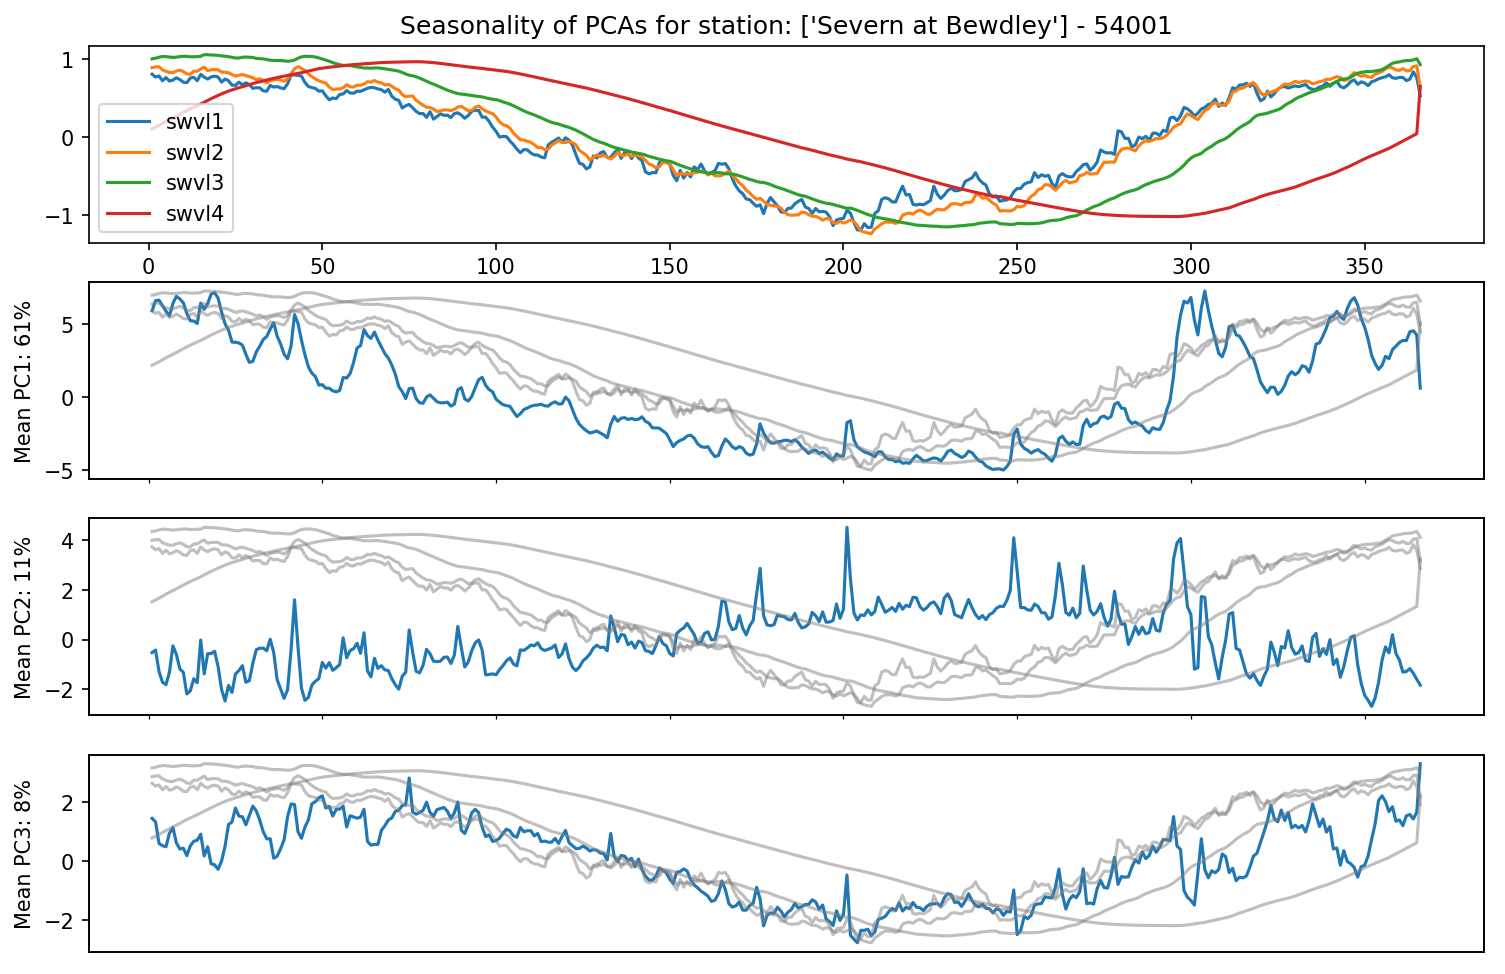

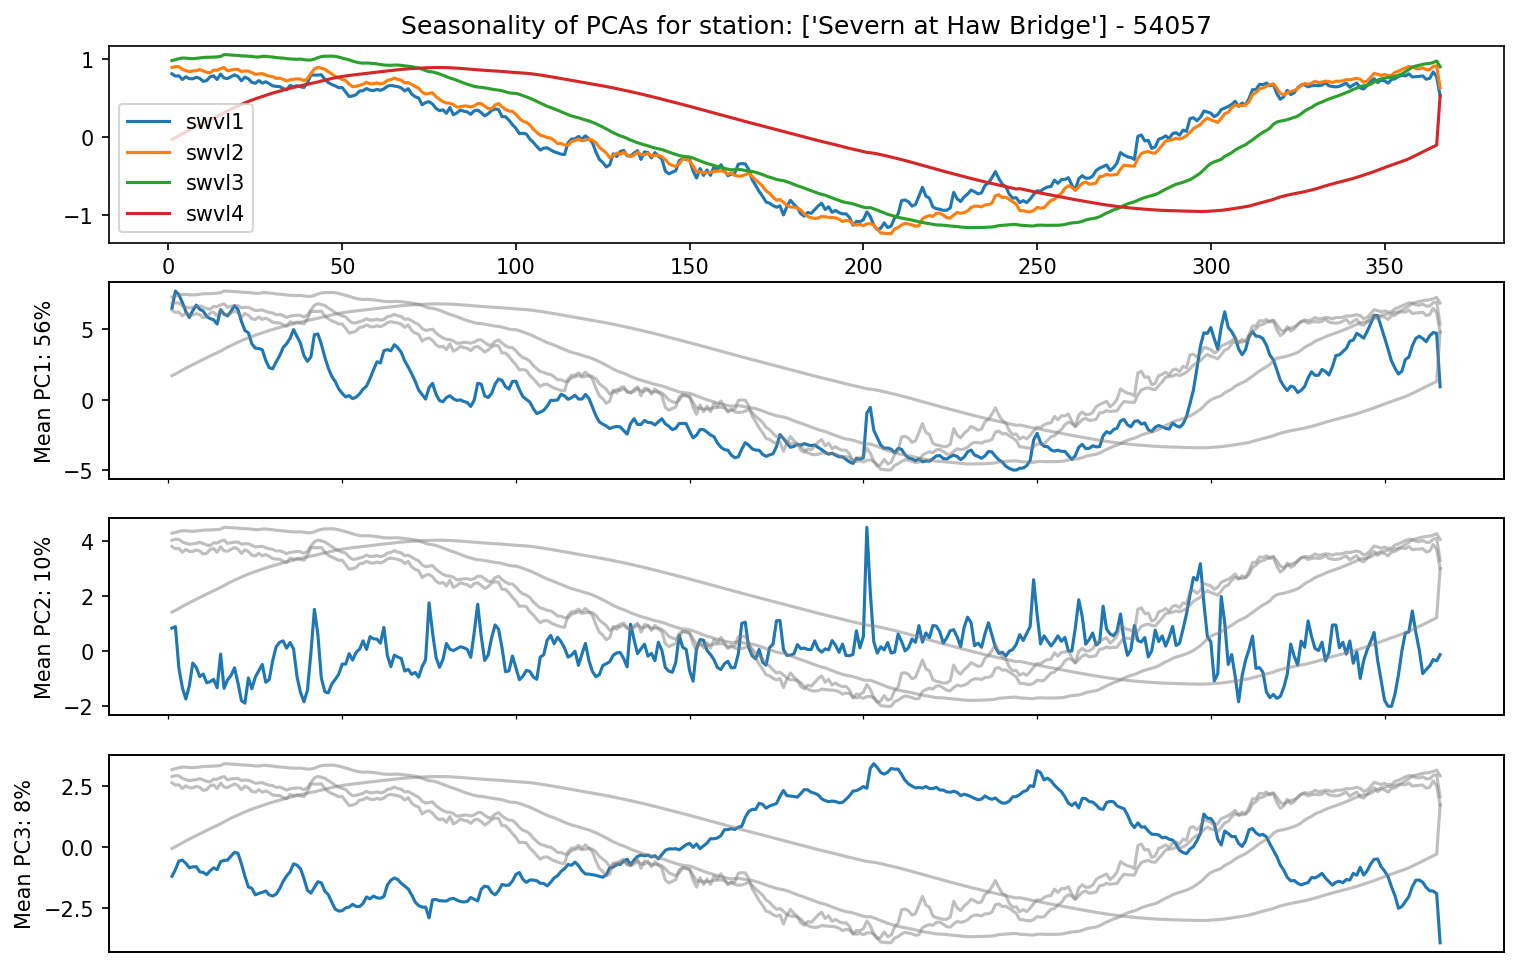

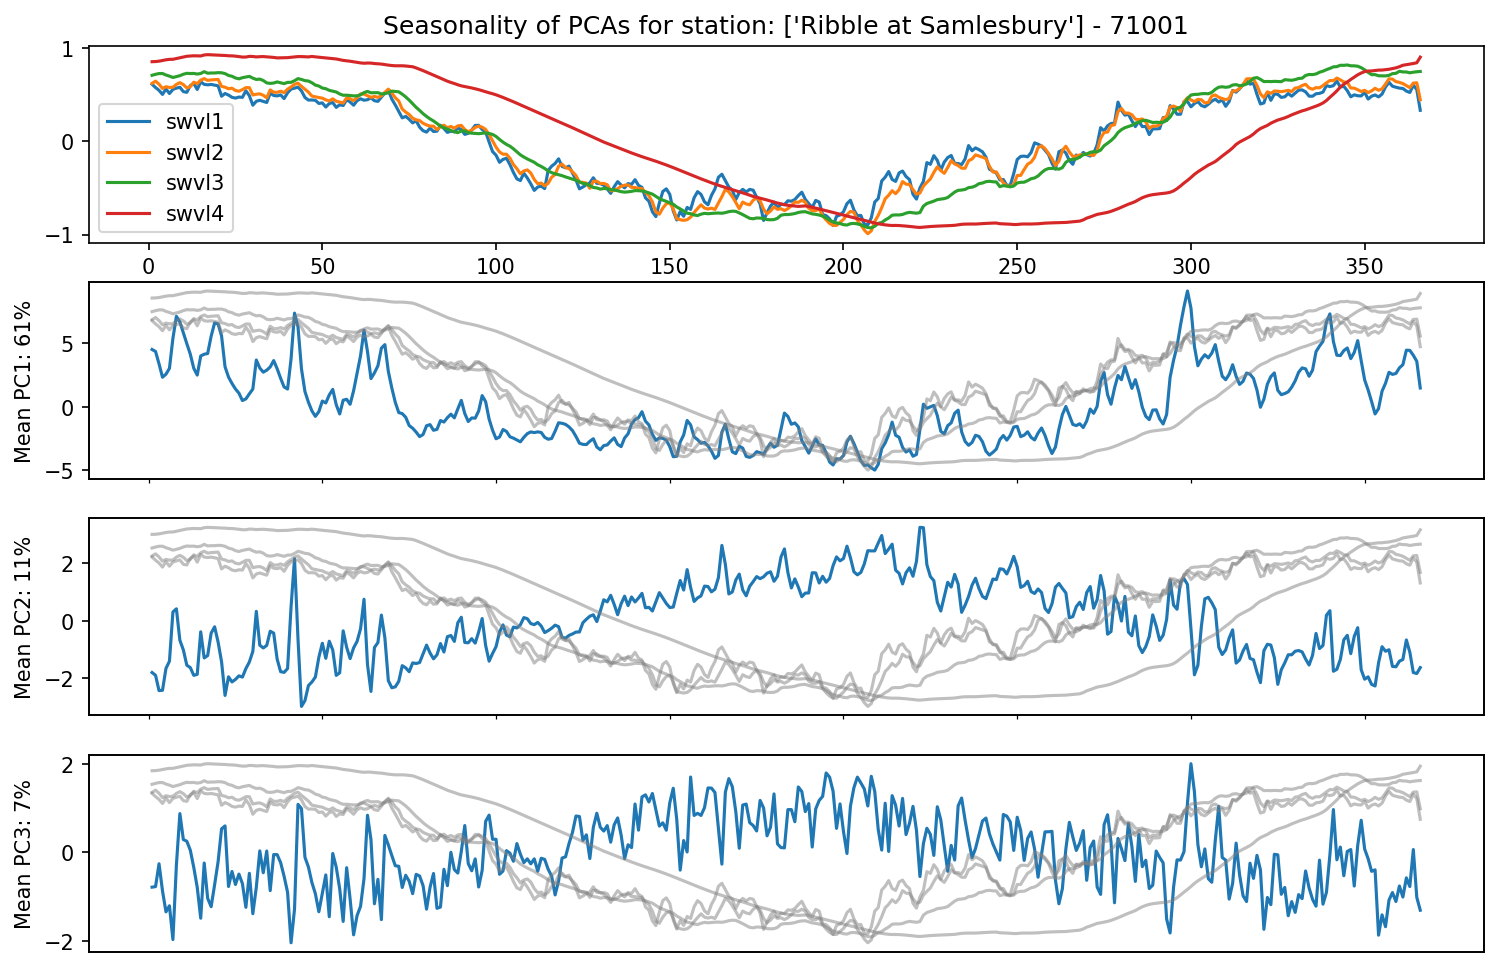

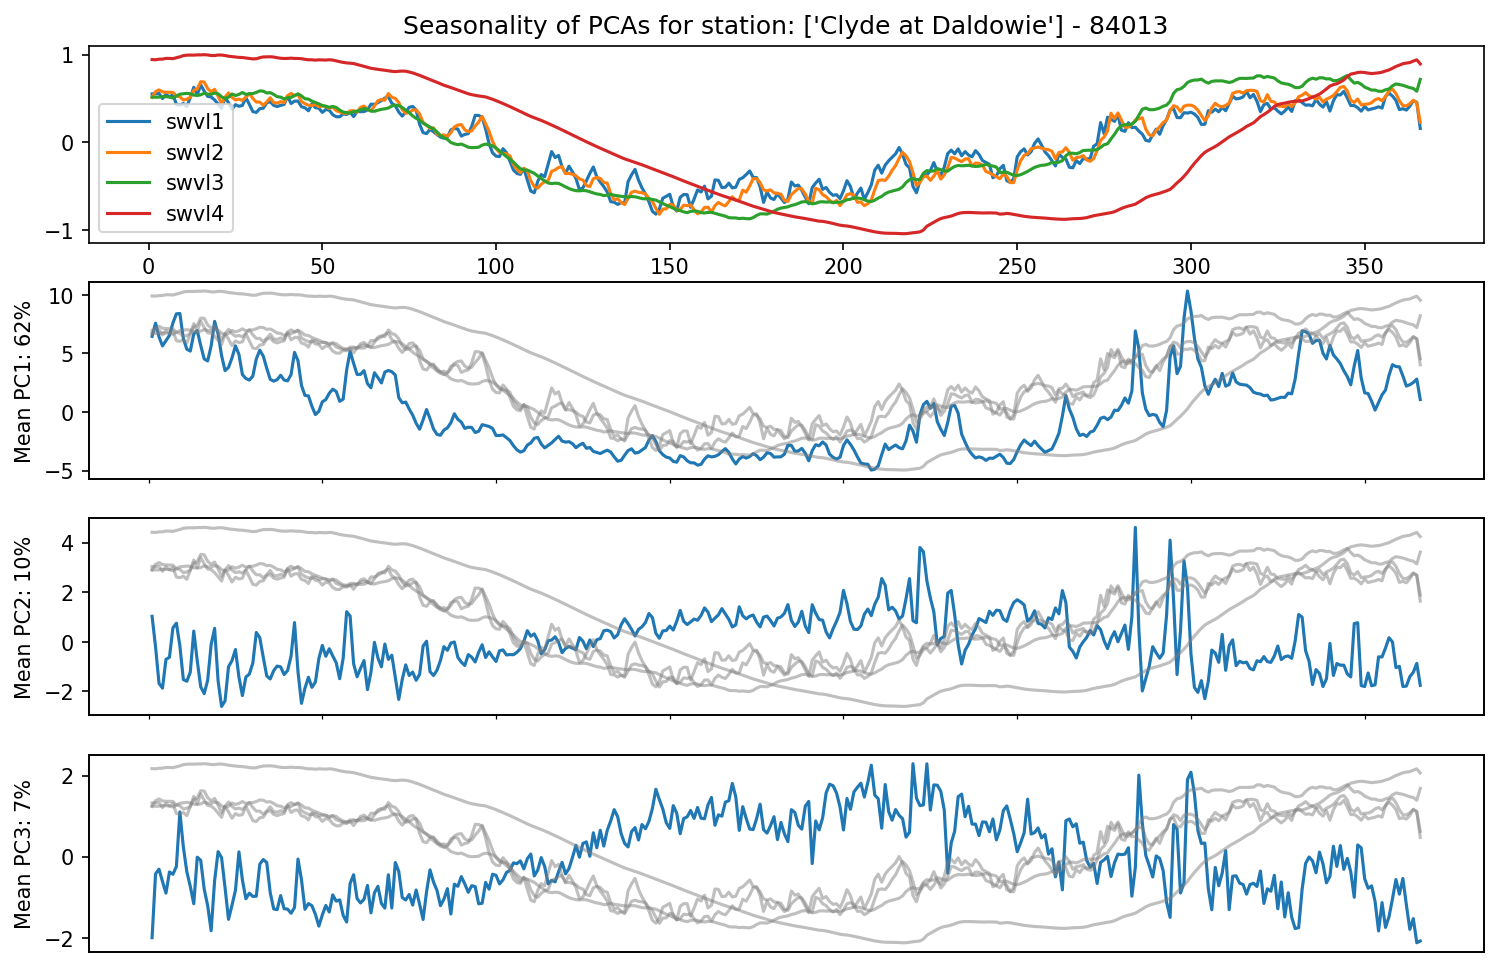

In [64]:
for ix, station in enumerate(all_pca.station_id.values):
    fig, ax = plot_obs_pca_clim(
        norm_climatology = norm_climatology,
        norm_pca = norm_pca,
        station = station,
        pca = pca_items[station],
        visualise_n_pcs=3,
    )
#     break
#     if ix == 3:
#         break
#     fig.savefig(data_dir / f"RUNOFF/sm_pca_plots/{station}.png")

In [59]:
station = "12002"
pca = pca_items[station]
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
weights = pca.explained_variance_ratio_
# print(eigenvalues)
# print(dir(pca))

In [60]:
# weights = 
# eigenvalues[:3] / eigenvalues.sum()

In [61]:
pc_d = all_pca.sel(station_id=station).groupby("time.dayofyear").mean().values
pc_d.shape

(366, 10)

In [62]:
weights

array([0.5330217 , 0.11826739, 0.07967525, 0.04761452, 0.03520817,
       0.02390032, 0.0235377 , 0.01853288, 0.01320617, 0.01303013],
      dtype=float32)

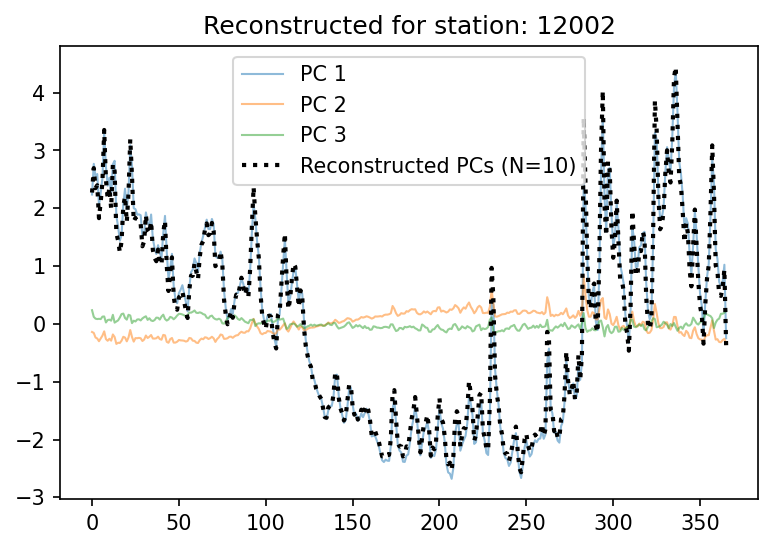

In [63]:
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
weights = pca.explained_variance_ratio_  # eigenvalues[:N_PCS] / eigenvalues.sum()

assert all(np.isclose((weights @ pc_d.T), np.dot(weights, pc_d.T)))

# obs_q.groupby("doy").mean().plot(label="Discharge", alpha=0.5, linewidth=1)
# sm_d.plot(label="Soil Moisture")
alphas = 0.5
fig, ax = plt.subplots()
ax.plot(pc_d[:, 0] * weights[0], label="PC 1", linewidth=1, alpha=alphas)
ax.plot(pc_d[:, 1] * weights[1], label="PC 2", linewidth=1, alpha=alphas)
ax.plot(pc_d[:, 2] * weights[2], label="PC 3", linewidth=1, alpha=alphas)
ax.plot((weights @ pc_d.T), label=f"Reconstructed PCs (N={N_PCS})", linewidth=2, color='k', ls=":")
ax.set_title(f"Reconstructed for station: {station}")
ax.legend();